<a id='top'></a>
# Table of Contents:  
1) [Loading Capital Bikeshare Historical Data](#capitalbikeshare)  
2) [Loading Live XML Feed Data](#xmlfeed)  
3) [Combine Capital Bikeshare and Live XML](#combine)  
4) [Explore the Capital Bikeshare and Live XML Combined Dataset](#explore1)  
5) [Loading CaBi Tracker Outage Data](#cabitracker)  
6) [Create Full Baseline Dataset](#fullbaseline)  
7) [General Data Exploration for Full Baseline](#explore2)  
8) [Generating Final Dataset](#Finaldf)  
9) [Station Forecasts](#forecast)

In [51]:
import os
import re
import pandas as pd
import numpy as np
import urllib.request
import shutil
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import datetime
from sklearn.metrics import mean_squared_error
import matplotlib.dates as md
import warnings; warnings.simplefilter('ignore')
sns.set_style("whitegrid")
%matplotlib inline
pd.options.mode.chained_assignment = None
#get current working directory
cwd = os.getcwd()

<a id='capitalbikeshare'></a>
# Load in Capital Bikeshare's Historical Trip Pattern Data
[Back to Top](#top)

To begin, I will read in the most recent, historical year of data available from Capital Bikeshare. This ranges from 2017 Q3(August) to the end of 2018 08(August). Each file is stored as a separate dataframe so that I can explore each one individually before combining them into one dataframe.

In [2]:
## 2017 Q3 to Q4
df_2017Q3 = pd.read_csv(cwd+'/Historical Data/2017Q3-capitalbikeshare-tripdata.csv')
df_2017Q4 = pd.read_csv(cwd+'/Historical Data/2017Q4-capitalbikeshare-tripdata.csv')
#All 8 months of 2018
df_201801 = pd.read_csv(cwd+'/Historical Data/201801_capitalbikeshare_tripdata.csv')
df_201802 = pd.read_csv(cwd+'/Historical Data/201802-capitalbikeshare-tripdata.csv')
df_201803 = pd.read_csv(cwd+'/Historical Data/201803-capitalbikeshare-tripdata.csv')
df_201804 = pd.read_csv(cwd+'/Historical Data/201804-capitalbikeshare-tripdata.csv')
df_201805= pd.read_csv(cwd+'/Historical Data/201805-capitalbikeshare-tripdata.csv')
df_201806= pd.read_csv(cwd+'/Historical Data/201806-capitalbikeshare-tripdata.csv')
df_201807= pd.read_csv(cwd+'/Historical Data/201807-capitalbikeshare-tripdata.csv')
df_201808= pd.read_csv(cwd+'/Historical Data/201808-capitalbikeshare-tripdata.csv')

Below I explore each dataframe so that I can determine whether or not they will combine easily.

In [3]:
df_2017Q3.info()
df_2017Q3.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1191585 entries, 0 to 1191584
Data columns (total 9 columns):
Duration                1191585 non-null int64
Start date              1191585 non-null object
End date                1191585 non-null object
Start station number    1191585 non-null int64
Start station           1191585 non-null object
End station number      1191585 non-null int64
End station             1191585 non-null object
Bike number             1191585 non-null object
Member type             1191585 non-null object
dtypes: int64(3), object(6)
memory usage: 81.8+ MB


,Duration,Start date,End date,Start station number,Start station,End station number,End station,Bike number,Member type
0,2762,2017-07-01 00:01:09,2017-07-01 00:47:11,31289,Henry Bacon Dr & Lincoln Memorial Circle NW,31289,Henry Bacon Dr & Lincoln Memorial Circle NW,W21474,Casual
1,2763,2017-07-01 00:01:24,2017-07-01 00:47:27,31289,Henry Bacon Dr & Lincoln Memorial Circle NW,31289,Henry Bacon Dr & Lincoln Memorial Circle NW,W22042,Casual


In [4]:
df_2017Q4.info()
df_2017Q4.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 815264 entries, 0 to 815263
Data columns (total 9 columns):
Duration                815264 non-null int64
Start date              815264 non-null object
End date                815264 non-null object
Start station number    815264 non-null int64
Start station           815264 non-null object
End station number      815264 non-null int64
End station             815264 non-null object
Bike number             815264 non-null object
Member type             815264 non-null object
dtypes: int64(3), object(6)
memory usage: 56.0+ MB


,Duration,Start date,End date,Start station number,Start station,End station number,End station,Bike number,Member type
0,197,2017-10-01 00:00:02,2017-10-01 00:03:19,31214,17th & Corcoran St NW,31229,New Hampshire Ave & T St NW,W21022,Member
1,434,2017-10-01 00:00:23,2017-10-01 00:07:38,31104,Adams Mill & Columbia Rd NW,31602,Park Rd & Holmead Pl NW,W00470,Member


In [5]:
df_201801.info()
df_201801.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168590 entries, 0 to 168589
Data columns (total 9 columns):
Duration                168590 non-null int64
Start date              168590 non-null object
End date                168590 non-null object
Start station number    168590 non-null int64
Start station           168590 non-null object
End station number      168590 non-null int64
End station             168590 non-null object
Bike number             168590 non-null object
Member type             168590 non-null object
dtypes: int64(3), object(6)
memory usage: 11.6+ MB


,Duration,Start date,End date,Start station number,Start station,End station number,End station,Bike number,Member type
0,552,2018-01-01 00:05:06,2018-01-01 00:14:18,31104,Adams Mill & Columbia Rd NW,31400,Georgia & New Hampshire Ave NW,W00886,Member
1,1282,2018-01-01 00:14:30,2018-01-01 00:35:53,31321,15th St & Constitution Ave NW,31321,15th St & Constitution Ave NW,W01435,Casual


In [6]:
df_201802.info()
df_201802.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182378 entries, 0 to 182377
Data columns (total 9 columns):
Duration                182378 non-null int64
Start date              182378 non-null object
End date                182378 non-null object
Start station number    182378 non-null int64
Start station           182378 non-null object
End station number      182378 non-null int64
End station             182378 non-null object
Bike number             182378 non-null object
Member type             182378 non-null object
dtypes: int64(3), object(6)
memory usage: 12.5+ MB


,Duration,Start date,End date,Start station number,Start station,End station number,End station,Bike number,Member type
0,892,2018-02-01 00:01:29,2018-02-01 00:16:21,31312,Wisconsin Ave & O St NW,31267,17th St & Massachusetts Ave NW,W21967,Member
1,501,2018-02-01 00:04:19,2018-02-01 00:12:40,31089,Court House Metro / 15th & N Uhle St,31079,Lee Hwy & N Cleveland St,W00938,Member


Since all dataframes seem to have similar information and data types, and have been created under the same standards through Capital Bikeshare, I will go ahead and standardize each dataframe's feature names. I will then combine all dataframes into one.

In [8]:
new_feature_names = ['Duration', 'Start_Date', 'End_Date', 'Start_Station_Number', 
                     'Start_Station', 'End_Station_Number', 'End_Station', 'Bike_Number', 
                     'Member_Type']

# New feature names for 2017
df_2017Q3.columns = new_feature_names
df_2017Q4.columns = new_feature_names
# New feature names for 2018
df_201801.columns = new_feature_names
df_201802.columns = new_feature_names
df_201803.columns = new_feature_names
df_201804.columns = new_feature_names
df_201805.columns= new_feature_names
df_201806.columns= new_feature_names
df_201807.columns= new_feature_names
df_201808.columns= new_feature_names
# Master CaBi Bike data frame with all data from 2017-2018 and dropping any duplicates 
bike_data = df_2017Q3.append([df_2017Q4,df_201801,df_201802,df_201803,df_201804,df_201805,df_201806,df_201807,df_201808])
bike_data.drop_duplicates(keep = False, inplace = True) 
# A quick view of the new dataframe
bike_data.info()
bike_data.head(2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4500802 entries, 0 to 403865
Data columns (total 9 columns):
Duration                int64
Start_Date              object
End_Date                object
Start_Station_Number    int64
Start_Station           object
End_Station_Number      int64
End_Station             object
Bike_Number             object
Member_Type             object
dtypes: int64(3), object(6)
memory usage: 343.4+ MB


,Duration,Start_Date,End_Date,Start_Station_Number,Start_Station,End_Station_Number,End_Station,Bike_Number,Member_Type
0,2762,2017-07-01 00:01:09,2017-07-01 00:47:11,31289,Henry Bacon Dr & Lincoln Memorial Circle NW,31289,Henry Bacon Dr & Lincoln Memorial Circle NW,W21474,Casual
1,2763,2017-07-01 00:01:24,2017-07-01 00:47:27,31289,Henry Bacon Dr & Lincoln Memorial Circle NW,31289,Henry Bacon Dr & Lincoln Memorial Circle NW,W22042,Casual


<a id='xmlfeed'></a>
# Load in a snapshot of Capital Bikeshare's Live XML Feed
Next, I will take a snapshot of the current state of Capital Bikeshare's stations through the Live XML Feed. I will need the Station capcity, latitude, and longitude for visualization  and analysis purposes.
[Back to Top](#top)

In [9]:
import os
import re
import pandas as pd
import numpy as np
import urllib.request
import shutil
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
import datetime
import time
import seaborn as sns
def get_station_xml():
    url = "https://www.capitalbikeshare.com/data/stations/bikeStations.xml"
    download_dir = 'xml_data'
    if not os.path.exists(download_dir):
        os.remove(download_dir)#if it exists remove it
        os.mkdir(download_dir)#make a new directory with the xml data
    file_name = os.path.join(download_dir, 'bike_stations.xml')
    with urllib.request.urlopen(url) as response, open(file_name, 'wb') as out_file:
        shutil.copyfileobj(response, out_file)
get_station_xml()

# Parse the XML file and return a dataframe object
def xml_to_pandas(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    l = []
    for station in root:
        d = {}
        for attrib in station:
            d[str(attrib.tag)] = str(attrib.text)
        l.append(d)

    df = pd.DataFrame.from_dict(l)
    return df
bike_stations = xml_to_pandas('xml_data/bike_stations.xml')
bike_stations['nbBikes'] = pd.to_numeric(bike_stations['nbBikes'])#conerts to numpy.int64
bike_stations['nbEmptyDocks'] = pd.to_numeric(bike_stations['nbEmptyDocks'])#conerts to numpy.int64
# Creating Bike status percentage from the current number of bikes and the sum of bikes and docks
# bike_stations['nbBikePerc'] = bike_stations['nbBikes']/bike_stations[bike_stations.columns].sum(axis=1)
# rounds up to the nearest 10% using numpy's around method
# bike_stations['nbBikePerc'] = pd.Series(bike_stations['nbBikePerc']).apply(lambda x: np.around(x, decimals = 1))

#For formatting time
#TIMESTR = time.strftime("%Y%m%d_%H%M%S")
#filename = "CaBi_Status" + TIMESTR + ".csv"
#bike_stations.to_csv(filename, index=False)

<a id='combine'></a>
# Combine the two datasets:
1) Capital Bikeshare's Historical Trip Data stored in bike_data  
2) Capital Bikeshare's Live XML Feed stored in station_status
[Back to Top](#top)

In [10]:
# Wrangle the resulting dataframe object and display
bike_stations['terminalName'] = bike_stations['terminalName'].astype(int)
bike_stations['lat'] = bike_stations['lat'].astype(float)
bike_stations['long'] = bike_stations['long'].astype(float)
station_status = bike_stations[['terminalName']]
station_status['Start_Location'] = list(zip(bike_stations['lat'], bike_stations['long']))#location
station_status['Start_Station_Capacity'] = (bike_stations['nbBikes'].astype(int) 
                                         + bike_stations['nbEmptyDocks'].astype(int))#total capacity

#This version is for the combination with the historical dataset later
station_status_copy = station_status.copy()


station_status['Street Address']=bike_stations['name']
station_status['location'] = station_status['Start_Location']
station_status['Bikes Available'] = bike_stations['nbBikes'].astype(int) 
station_status['Docks Empty'] = bike_stations['nbEmptyDocks'].astype(int) 
station_status['Total Station Capacity']=station_status['Start_Station_Capacity']

#dropping unnecessary columns
station_status.drop(['Start_Station_Capacity','Start_Location',], axis=1, inplace=True)

#Getting current time and timezone for the Time Imported mapbox feature
from datetime import datetime
from pytz import timezone
station_status['Time Imported']= datetime.now(timezone('EST')).strftime('%I:%M:%S')

#filename = "Current_CaBiStatus"+ ".csv"
#station_status.to_csv(filename, index=False)

In [11]:
# Combine original dataframe with new station lat/long data
# using a left join on End Station and then Start Station
station_status_copy.columns = ['Start_Station_Number', 'Start_Location', 'Start_Station_Capacity']
bike_data = pd.merge(bike_data, station_status_copy, how='left', on='Start_Station_Number')
#again but for end station number, location, and capacity
station_status_copy.columns = ['End_Station_Number', 'End_Location', 'End_Station_Capacity']
bike_data = pd.merge(bike_data, station_status_copy, how='left', on='End_Station_Number')

# Display the first several rows of the new dataframe
bike_data.head()

,Duration,Start_Date,End_Date,Start_Station_Number,Start_Station,End_Station_Number,End_Station,Bike_Number,Member_Type,Start_Location,Start_Station_Capacity,End_Location,End_Station_Capacity
0,2762,2017-07-01 00:01:09,2017-07-01 00:47:11,31289,Henry Bacon Dr & Lincoln Memorial Circle NW,31289,Henry Bacon Dr & Lincoln Memorial Circle NW,W21474,Casual,"(38.890544, -77.049379)",19.0,"(38.890544, -77.049379)",19.0
1,2763,2017-07-01 00:01:24,2017-07-01 00:47:27,31289,Henry Bacon Dr & Lincoln Memorial Circle NW,31289,Henry Bacon Dr & Lincoln Memorial Circle NW,W22042,Casual,"(38.890544, -77.049379)",19.0,"(38.890544, -77.049379)",19.0
2,690,2017-07-01 00:01:45,2017-07-01 00:13:16,31122,16th & Irving St NW,31299,Connecticut Ave & R St NW,W01182,Member,"(38.928893, -77.03625)",18.0,"(38.912644, -77.04564)",17.0
3,134,2017-07-01 00:01:46,2017-07-01 00:04:00,31201,15th & P St NW,31267,17th St & Massachusetts Ave NW,W22829,Member,"(38.90985, -77.034438)",14.0,"(38.908142, -77.038359)",15.0
4,587,2017-07-01 00:02:05,2017-07-01 00:11:52,31099,Madison & N Henry St,31907,Franklin & S Washington St,W22223,Casual,"(38.813485, -77.049468)",15.0,"(38.798133, -77.0487)",19.0


<a id='explore1'></a>
# Explore the new, combined dataframe for inconsistencies:
[Back to Top](#top)

In [12]:
# Determine whether there are any missing values
print('Missing values:')
for feature in bike_data.columns:
    print(feature + ':', bike_data[feature].isnull().values.ravel().sum())

Missing values:
Duration: 0
Start_Date: 0
End_Date: 0
Start_Station_Number: 0
Start_Station: 0
End_Station_Number: 0
End_Station: 0
Bike_Number: 0
Member_Type: 0
Start_Location: 4090
Start_Station_Capacity: 4090
End_Location: 3336
End_Station_Capacity: 3336


Seeing as the newly formed features, Start_Location, End_Location, Start_Station_Capacity, and End_Station_Capacity contain missing values I need to determine which stations are missing entries, and why this might be the case.

In [13]:
# Print out unique station numbers to check which stations do not have associated locations or capacities  
start_subset_test = bike_data[bike_data['Start_Location'].isnull()]
print('Start Stations without locations:', start_subset_test['Start_Station_Number'].unique())
start_subset_test = bike_data[bike_data['Start_Station_Capacity'].isnull()]
print('Start Stations without capacities:', start_subset_test['Start_Station_Number'].unique())

end_subset_test = bike_data[bike_data['End_Location'].isnull()]
print('End Stations without locations:', end_subset_test['End_Station_Number'].unique())
end_subset_test = bike_data[bike_data['End_Station_Capacity'].isnull()]
print('End Stations without capacities:', end_subset_test['End_Station_Number'].unique())

Start Stations without locations: [31504 32009]
Start Stations without capacities: [31504 32009]
End Stations without locations: [31504 32009]
End Stations without capacities: [31504 32009]


Great, it appears the only stations that are without locations on either end are Station Number **31504** and **32009**. So now I will remove any rows that have these station numbers and check if they are gone.

In [22]:
#Removing rows that have this start or end station number
bike_data =  bike_data[~(bike_data['Start_Station_Number']==31504)]
bike_data =  bike_data[~(bike_data['Start_Station_Number']==32009)]
bike_data =  bike_data[~(bike_data['End_Station_Number']==31504)]
bike_data =  bike_data[~(bike_data['End_Station_Number']==32009)]


In [24]:
# Are the missing values gone?
print('Missing Start Station Location:', \
      bike_data['Start_Location'].isnull().values.ravel().sum())
print('Missing Start Station Capacity:', \
      bike_data['Start_Station_Capacity'].isnull().values.ravel().sum())
print('Missing End Station Location:', \
      bike_data['End_Location'].isnull().values.ravel().sum())
print('Missing End Station Capacity:', \
      bike_data['End_Station_Capacity'].isnull().values.ravel().sum())

Missing Start Station Location: 0
Missing Start Station Capacity: 0
Missing End Station Location: 0
Missing End Station Capacity: 0


Now that we have a full data set of start and end locations we can exam the features for any other issues.

In [25]:
# Determine how many different values each feature can take
print('Number of unique values:')
for feature in bike_data.columns:
    print(feature + ':', len(list(bike_data[feature].unique())))

Number of unique values:
Duration: 22831
Start_Date: 4001183
End_Date: 3997561
Start_Station_Number: 507
Start_Station: 514
End_Station_Number: 507
End_Station: 514
Bike_Number: 4764
Member_Type: 2
Start_Location: 507
Start_Station_Capacity: 31
End_Location: 507
End_Station_Capacity: 31


As we can see above, some features have an appropriate number of values while others do not. **Duration, Start_Date, End_Date, and Member_Type** are as expected. Per Capital Bikeshare's website, there are **4300 bikes** available at over **500 stations**. Given this information, the number of unique Bike_Number's may be too high, but this could be a function of changing bike numbers over the course of the year. Lastly, it is odd that Start_Station_Number, End_Station_Number, Start_Location and End_Location have **507 values** while Start_Station and End_Station have **514 values**. Since I would have expected these features to match, I will explore and clean further below.

In [26]:
# Split the original data into a dataframe that shows only the start station information
start_df = pd.DataFrame(bike_data['Start_Station'].value_counts())
start_df.reset_index(drop=False, inplace=True)
start_df.columns = ['Start_Station', 'Counts']
start_df = start_df.merge(bike_data[['Start_Location', 'Start_Station_Number', 'Start_Station']], 
                          how='left', on='Start_Station')
start_df.drop_duplicates(inplace=True)
#
start_df['Start_Location_Lat'] = \
    start_df['Start_Location'].map(lambda x: str(x).split(', ')[0].lstrip('('))
start_df['Start_Location_Long'] = \
    start_df['Start_Location'].map(lambda x: str(x).split(', ')[-1].rstrip(')'))
start_df.drop('Start_Location', axis=1, inplace=True)
start_df = start_df.sort_values(by='Start_Station_Number')
start_df.reset_index(drop=True, inplace=True)

start_df.head()

,Start_Station,Counts,Start_Station_Number,Start_Location_Lat,Start_Location_Long
0,Eads St & 15th St S,3348,31000,38.858971,-77.05323
1,18th & Eads St.,3095,31001,38.85725,-77.05332
2,Crystal Dr & 20th St S,858,31002,38.856425,-77.049232
3,20th & Crystal Dr,7826,31002,38.856425,-77.049232
4,15th & Crystal Dr,5596,31003,38.86017,-77.049593


In [27]:
# Split the original data into a dataframe that shows only the end station information
end_df = pd.DataFrame(bike_data['End_Station'].value_counts())
end_df.reset_index(drop=False, inplace=True)
end_df.columns = ['End_Station', 'Counts']
end_df = end_df.merge(bike_data[['End_Location', 'End_Station_Number', 'End_Station']], 
                      how='left', on='End_Station')
end_df.drop_duplicates(inplace=True)
end_df['End_Location_Lat'] = \
    end_df['End_Location'].map(lambda x: str(x).split(', ')[0].lstrip('('))
end_df['End_Location_Long'] = \
    end_df['End_Location'].map(lambda x: str(x).split(', ')[-1].rstrip(')'))
end_df.drop('End_Location', axis=1, inplace=True)
end_df = end_df.sort_values(by='End_Station_Number')
end_df.reset_index(drop=True, inplace=True)

end_df.head()

,End_Station,Counts,End_Station_Number,End_Location_Lat,End_Location_Long
0,Eads St & 15th St S,3355,31000,38.858971,-77.05323
1,18th & Eads St.,2672,31001,38.85725,-77.05332
2,Crystal Dr & 20th St S,889,31002,38.856425,-77.049232
3,20th & Crystal Dr,8530,31002,38.856425,-77.049232
4,Crystal Dr & 15th St S,601,31003,38.86017,-77.049593


In [29]:
# Print out descriptive stats to check if the same problems persist
print('Unique Start Station Lat/Long:', len(list(bike_data['Start_Location'].unique())))
print('Unique Start Station Numbers:', len(list(start_df['Start_Station_Number'].unique())))
print('Unique Start Station Names:', len(list(start_df['Start_Station'].unique())))
print('Unique End Station Lat/Long:', len(list(bike_data['End_Location'].unique())))
print('Unique End Station Numbers:', len(list(end_df['End_Station_Number'].unique())))
print('Unique End Station Names:', len(list(end_df['End_Station'].unique())))

Unique Start Station Lat/Long: 507
Unique Start Station Numbers: 507
Unique Start Station Names: 514
Unique End Station Lat/Long: 507
Unique End Station Numbers: 507
Unique End Station Names: 514


It is clear that there is a discrepency between the **Station names** and the **Station numbers and lat/long pairs** possibly from overlapping names for 7 numbers and lat and long pairs. I look further into the dataframes to determine the exact issue stations. 

In [30]:
# Determine where exactly there are issues in the start dataframe
for row in start_df.itertuples():
    try:
        if start_df.get_value(row[0], 'Start_Station_Number') == \
            start_df.get_value(row[0]-1, 'Start_Station_Number'):
            print('Start_Station_Number:', start_df.get_value(row[0]-1, 'Start_Station_Number'), 
                  '\nStart_Station Name:', start_df.get_value(row[0]-1, 'Start_Station'), 
                  '\nName Count:', start_df.get_value(row[0]-1, 'Counts'),
                  'Lat:', start_df.get_value(row[0]-1, 'Start_Location_Lat'),
                  'Long:', start_df.get_value(row[0]-1, 'Start_Location_Long'))
            print('Start_Station_Number:', start_df.get_value(row[0], 'Start_Station_Number'), 
                  '\nStart_Station Name:', start_df.get_value(row[0], 'Start_Station'), 
                  '\nName Count:', start_df.get_value(row[0], 'Counts'),
                  'Lat:', start_df.get_value(row[0], 'Start_Location_Lat'),
                  'Long:', start_df.get_value(row[0], 'Start_Location_Long'), end='\n\n')
    except:
        pass

Start_Station_Number: 31002 
Start_Station Name: Crystal Dr & 20th St S 
Name Count: 858 Lat: 38.856425 Long: -77.049232
Start_Station_Number: 31002 
Start_Station Name: 20th & Crystal Dr 
Name Count: 7826 Lat: 38.856425 Long: -77.049232

Start_Station_Number: 31003 
Start_Station Name: 15th & Crystal Dr 
Name Count: 5596 Lat: 38.86017 Long: -77.049593
Start_Station_Number: 31003 
Start_Station Name: Crystal Dr & 15th St S 
Name Count: 563 Lat: 38.86017 Long: -77.049593

Start_Station_Number: 31009 
Start_Station Name: Crystal Dr & 27th St S 
Name Count: 326 Lat: 38.848466 Long: -77.051514
Start_Station_Number: 31009 
Start_Station Name: 27th & Crystal Dr 
Name Count: 5127 Lat: 38.848466 Long: -77.051514

Start_Station_Number: 31011 
Start_Station Name: Crystal Dr & 23rd St S 
Name Count: 649 Lat: 38.8533 Long: -77.0498
Start_Station_Number: 31011 
Start_Station Name: 23rd & Crystal Dr 
Name Count: 5964 Lat: 38.8533 Long: -77.0498

Start_Station_Number: 31062 
Start_Station Name: Roose

In [31]:
# Determine where exactly there are issues in the end dataframe
for row in end_df.itertuples():
    try:
        if end_df.get_value(row[0], 'End_Station_Number') == \
            end_df.get_value(row[0]-1, 'End_Station_Number'):
            print('End_Station_Number:', end_df.get_value(row[0]-1, 'End_Station_Number'), 
                  '\nEnd_Station Name:', end_df.get_value(row[0]-1, 'End_Station'), 
                  '\nName Count:', end_df.get_value(row[0]-1, 'Counts'),
                  'Lat:', end_df.get_value(row[0]-1, 'End_Location_Lat'),
                  'Long:', end_df.get_value(row[0]-1, 'End_Location_Long'))
            print('End_Station_Number:', end_df.get_value(row[0], 'End_Station_Number'), 
                  '\nEnd_Station Name:', end_df.get_value(row[0], 'End_Station'), 
                  '\nName Count:', end_df.get_value(row[0], 'Counts'),
                  'Lat:', end_df.get_value(row[0], 'End_Location_Lat'),
                  'Long:', end_df.get_value(row[0], 'End_Location_Long'), end='\n\n')
    except:
        pass

End_Station_Number: 31002 
End_Station Name: Crystal Dr & 20th St S 
Name Count: 889 Lat: 38.856425 Long: -77.049232
End_Station_Number: 31002 
End_Station Name: 20th & Crystal Dr 
Name Count: 8530 Lat: 38.856425 Long: -77.049232

End_Station_Number: 31003 
End_Station Name: Crystal Dr & 15th St S 
Name Count: 601 Lat: 38.86017 Long: -77.049593
End_Station_Number: 31003 
End_Station Name: 15th & Crystal Dr 
Name Count: 5960 Lat: 38.86017 Long: -77.049593

End_Station_Number: 31009 
End_Station Name: Crystal Dr & 27th St S 
Name Count: 371 Lat: 38.848466 Long: -77.051514
End_Station_Number: 31009 
End_Station Name: 27th & Crystal Dr 
Name Count: 5449 Lat: 38.848466 Long: -77.051514

End_Station_Number: 31011 
End_Station Name: 23rd & Crystal Dr 
Name Count: 6789 Lat: 38.8533 Long: -77.0498
End_Station_Number: 31011 
End_Station Name: Crystal Dr & 23rd St S 
Name Count: 699 Lat: 38.8533 Long: -77.0498

End_Station_Number: 31062 
End_Station Name: S George Mason Dr & 13th St S 
Name Count

It is clear that, when taking into account both start and end station numbers, the same station numbers and lat/long pairs appear to be repeated. Each station number and lat/long pair above is related to two different station names. Further, the station name counts are not repeated, which indicates that the station numbers are not duplicated, but the station names have been changing over time. For this reason, and because this is a unique identifier that is not predictive, I will drop the Start_Station and End_Station features from the data set.

In [33]:
bike_data.drop(['Start_Station', 'End_Station'], 
                axis=1, inplace=True)
start_df.drop(['Start_Station'], 
                axis=1, inplace=True)
end_df.drop(['End_Station'], 
                axis=1, inplace=True)

#Save dataframe to csv
filename = "CaBiStation_Heatmap.csv"
#start_df.to_csv(filename, index=False)
#end_df.to_csv(filename, index=False)

bike_data.to_csv(filename, index=False)
bike_data.head()

,Duration,Start_Date,End_Date,Start_Station_Number,End_Station_Number,Bike_Number,Member_Type,Start_Location,Start_Station_Capacity,End_Location,End_Station_Capacity
0,2762,2017-07-01 00:01:09,2017-07-01 00:47:11,31289,31289,W21474,Casual,"(38.890544, -77.049379)",19.0,"(38.890544, -77.049379)",19.0
1,2763,2017-07-01 00:01:24,2017-07-01 00:47:27,31289,31289,W22042,Casual,"(38.890544, -77.049379)",19.0,"(38.890544, -77.049379)",19.0
2,690,2017-07-01 00:01:45,2017-07-01 00:13:16,31122,31299,W01182,Member,"(38.928893, -77.03625)",18.0,"(38.912644, -77.04564)",17.0
3,134,2017-07-01 00:01:46,2017-07-01 00:04:00,31201,31267,W22829,Member,"(38.90985, -77.034438)",14.0,"(38.908142, -77.038359)",15.0
4,587,2017-07-01 00:02:05,2017-07-01 00:11:52,31099,31907,W22223,Casual,"(38.813485, -77.049468)",15.0,"(38.798133, -77.0487)",19.0


<a id='cabitracker'></a>
# Load CaBi Tracker's Historical System Outage Data
[Back to Top](#top)

In [34]:
# Read in CaBi Tracker data
'''
08/31/2017-08/31/2018
2017: export24-30
8/31-12/31

2018: export07-23
01/01 - 08/31
'''
## 08/31/2017 
export24= pd.read_csv(cwd+'/outage/export (24).csv')
export25= pd.read_csv(cwd+'/outage/export (25).csv')
export26= pd.read_csv(cwd+'/outage/export (26).csv')
export27= pd.read_csv(cwd+'/outage/export (27).csv')
export28= pd.read_csv(cwd+'/outage/export (28).csv')
export29= pd.read_csv(cwd+'/outage/export (29).csv')
export30= pd.read_csv(cwd+'/outage/export (30).csv')
export31= pd.read_csv(cwd+'/outage/export (31).csv')
#export32= pd.read_csv(cwd+'/outage/export (32).csv')
outage_data_2017 = export31.append([export30,export29,export28,export27,export26,export25,export24])
 
# 08/31/2018
export7 = pd.read_csv(cwd+'/outage/export (7).csv')#january 2018
export8 = pd.read_csv(cwd+'/outage/export (8).csv')
export9 = pd.read_csv(cwd+'/outage/export (9).csv')
export10= pd.read_csv(cwd+'/outage/export (10).csv')
export11= pd.read_csv(cwd+'/outage/export (11).csv')
export12= pd.read_csv(cwd+'/outage/export (12).csv')
export13= pd.read_csv(cwd+'/outage/export (13).csv')
export14= pd.read_csv(cwd+'/outage/export (14).csv')
export15= pd.read_csv(cwd+'/outage/export (15).csv')
export16= pd.read_csv(cwd+'/outage/export (16).csv')
export17= pd.read_csv(cwd+'/outage/export (17).csv')
export18= pd.read_csv(cwd+'/outage/export (18).csv')
export19= pd.read_csv(cwd+'/outage/export (19).csv')
export20= pd.read_csv(cwd+'/outage/export (20).csv')
export21= pd.read_csv(cwd+'/outage/export (21).csv')
export22= pd.read_csv(cwd+'/outage/export (22).csv')
export23= pd.read_csv(cwd+'/outage/export (23).csv')
outage_data_2018 = export23.append([export22, export21, export20, export19,export18,export17,export16,export15,
                                   export14,export13,export12,export11,export10,export9,export8,export7])

outage_data = outage_data_2017.append([outage_data_2018])

# Display outage data
outage_data.info()
outage_data.head(2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1687061 entries, 0 to 56882
Data columns (total 6 columns):
Terminal Number    1687061 non-null int64
Station Name       1687061 non-null object
Status             1687061 non-null object
Start              1687061 non-null object
End                1687061 non-null object
Duration           1687061 non-null int64
dtypes: int64(2), object(4)
memory usage: 90.1+ MB


,Terminal Number,Station Name,Status,Start,End,Duration
0,31516,Rhode Island Ave Metro,near full,2017-12-31 15:26:55,2018-01-01 23:25:51,1919
1,31516,Rhode Island Ave Metro,near full dockable,2017-12-31 15:26:55,2018-01-01 23:25:51,1919


In [35]:
# Sorting outage dataframe by start datetime and then dropping duplicates
outage_data.sort_values(by=['Start'], inplace = True)
outage_data.drop_duplicates(keep = False, inplace = True) 
# Rename column names
outage_data.columns = ['Station_Number', 'Station_Name',
                      'Status', 'Start', 'End', 'Duration']
outage_data['Start'] = pd.to_datetime(outage_data['Start'], infer_datetime_format=True)
outage_data['End'] = pd.to_datetime(outage_data['End'], infer_datetime_format=True)

# Display outage data
outage_data.info()
outage_data.head(2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1685408 entries, 47480 to 21
Data columns (total 6 columns):
Station_Number    1685408 non-null int64
Station_Name      1685408 non-null object
Status            1685408 non-null object
Start             1685408 non-null datetime64[ns]
End               1685408 non-null datetime64[ns]
Duration          1685408 non-null int64
dtypes: datetime64[ns](2), int64(2), object(2)
memory usage: 90.0+ MB


,Station_Number,Station_Name,Status,Start,End,Duration
47480,31320,Nebraska Ave/AU East Campus,empty,2017-08-31 17:28:55,2017-09-01 00:00:59,392
47481,31626,15th St & Massachusetts Ave SE,full,2017-08-31 21:43:56,2017-09-01 00:00:59,137


In [36]:
# Take only the first outage notification for each station
outage_data_reduced = pd.DataFrame()
no_outage_list = []
for station in list(bike_data['Start_Station_Number'].unique()): 
    temp_df = outage_data[outage_data['Station_Number'] == station].sort_values(by='Start')
    try:
        outage_data_reduced = outage_data_reduced.append(temp_df.iloc[0])
    except:
        no_outage_list.append(station)
    
print('There is no outage data for {} stations.'.format(len(no_outage_list)))
outage_data_reduced.head()

There is no outage data for 0 stations.


,Duration,End,Start,Station_Name,Station_Number,Status
47412,292.0,2017-09-01 07:06:52,2017-09-01 02:14:59,Henry Bacon Dr & Lincoln Memorial Circle NW,31289.0,empty
47286,48.0,2017-09-01 09:14:56,2017-09-01 08:27:01,16th & Irving St NW,31122.0,empty
47362,2.0,2017-09-01 08:18:01,2017-09-01 08:15:56,15th & P St NW,31201.0,empty
43154,235.0,2017-09-05 12:10:54,2017-09-05 08:15:56,Madison & N Henry St,31099.0,empty
47401,3.0,2017-09-01 07:22:57,2017-09-01 07:20:01,North Capitol St & F St NW,31624.0,empty


With the following checks i will be able to:  
**1)** Determine if stations have empty or full notifications 
**2)** Accurately determine how many bikes to start with at these stations at time 0  

In [38]:
# Sanity check before taking stations out from bike_data 
print('{} start stations; {} end stations'\
      .format(len(list(bike_data['Start_Station_Number'].unique())), 
              len(list(bike_data['End_Station_Number'].unique()))))

507 start stations; 507 end stations


In [39]:
# Take out stations that do not have any empty or full notifications
bike_data = bike_data[np.logical_not(bike_data['Start_Station_Number'].isin(no_outage_list))]
bike_data = bike_data[np.logical_not(bike_data['End_Station_Number'].isin(no_outage_list))]

# Take out unecessary features from bike_data and prepare to split
bike_data.drop(['Duration', 'Bike_Number', 'Member_Type', 'Start_Location', 
                'End_Location'], axis=1, inplace=True)
bike_data['Status'] = np.nan#To fill in with suggestions later
bike_data['Start_Date'] = pd.to_datetime(bike_data['Start_Date'], infer_datetime_format=True)
bike_data['End_Date'] = pd.to_datetime(bike_data['End_Date'], infer_datetime_format=True)

# Display
bike_data.head(2)

,Start_Date,End_Date,Start_Station_Number,End_Station_Number,Start_Station_Capacity,End_Station_Capacity,Status
0,2017-07-01 00:01:09,2017-07-01 00:47:11,31289,31289,19.0,19.0,NaN
1,2017-07-01 00:01:24,2017-07-01 00:47:27,31289,31289,19.0,19.0,NaN
2,2017-07-01 00:01:45,2017-07-01 00:13:16,31122,31299,18.0,17.0,NaN
3,2017-07-01 00:01:46,2017-07-01 00:04:00,31201,31267,14.0,15.0,NaN
4,2017-07-01 00:02:05,2017-07-01 00:11:52,31099,31907,15.0,19.0,NaN


In [40]:
# Sanity check after taking stations out
print('{} start stations; {} end stations'\
      .format(len(list(bike_data['Start_Station_Number'].unique())), 
              len(list(bike_data['End_Station_Number'].unique()))))

507 start stations; 507 end stations


<a id='fullbaseline'></a>
# Create a baseline for the final, combined dataframe and create target variables
Here I will create two target variables: 
**1)** The number of bikes at a station and **2)** the percent capacity at a station. The data I have been wrangling above, in bike_data, is historical trip data, so it is only part of what is needed to back out bikes and percent capacity at each station. I will bring in the second part of the needed data from CaBi Tracker, which shows the points in time that any station starts an empty cycle, ends an empty cycle, starts a full cycle, and ends a full cycle. Merging these two data sets together should guide me in determining the flow of bikes between stations.  
[Back to Top](#top)

In [41]:
discrete_bike_data = pd.DataFrame()

for station in list(bike_data['Start_Station_Number'].unique()): 
    
    # Select subsets of the bike_data and outage_data dataframes
    bike_data_subset = \
        bike_data[(bike_data['Start_Station_Number'] == station) | \
                  (bike_data['End_Station_Number'] == station)]
    outage_data_subset = outage_data_reduced[outage_data_reduced['Station_Number'] == station]
    
    # Split bike_data_subset into a start station dataframe that matches the station
    # The resulting dataframe only includes a 'start date' and an action to subtract a bike
    bike_data_subset_start = \
        bike_data_subset[bike_data_subset['Start_Station_Number'] == station]
    bike_data_subset_start.drop(['End_Date', 'Start_Station_Number', 
                                 'End_Station_Number', 'End_Station_Capacity'], 
                                axis=1, inplace=True)
    bike_data_subset_start['Status'] = 'subtract bike'
    bike_data_subset_start.set_index('Start_Date', drop=False, inplace=True)

    # Split bike_data_subset into a end station dataframe that matches the station
    # The resulting dataframe only includes a 'start date' and an action to add a bike
    bike_data_subset_end = bike_data_subset[bike_data_subset['End_Station_Number'] == station]
    bike_data_subset_end.drop(['Start_Date', 'Start_Station_Number', 
                               'End_Station_Number', 'Start_Station_Capacity'], 
                              axis=1, inplace=True)
    bike_data_subset_end.columns = ['Start_Date', 'Start_Station_Capacity', 'Status']
    bike_data_subset_end['Status'] = 'add bike'
    bike_data_subset_end.set_index('Start_Date', drop=False, inplace=True)
    
    if outage_data_subset.iloc[0].loc['Status'] == 'empty':
        # Split outage_data_subset for when an empty notification starts
        outage_data_subset_status = \
            outage_data_subset.drop(['End', 'Station_Name', 'Duration'], axis=1)
        outage_data_subset_status = \
            outage_data_subset_status[outage_data_subset_status['Status'] == 'empty']
        outage_data_subset_status['Status'] = 'empty'
        outage_data_subset_status.columns = ['Start_Date', 'Station_Number', 'Status']
        outage_data_subset_status['Start_Station_Capacity'] = \
            bike_data_subset_start['Start_Station_Capacity'].iloc[0]
        outage_data_subset_status.set_index('Start_Date', drop=False, inplace=True)

    else:
        # Split outage_data_subset for when a full notification starts
        outage_data_subset_status = \
            outage_data_subset.drop(['End', 'Station_Name', 'Duration'], axis=1)
        outage_data_subset_status = \
            outage_data_subset_status[outage_data_subset_status['Status'] == 'full']
        outage_data_subset_status['Status'] = 'full'
        outage_data_subset_status.columns = ['Start_Date', 'Station_Number', 'Status']
        outage_data_subset_status['Start_Station_Capacity'] = \
            bike_data_subset_start['Start_Station_Capacity'].iloc[0]
        outage_data_subset_status.set_index('Start_Date', drop=False, inplace=True)

    # Combine the discretized dataframes
    combined_subset = \
        bike_data_subset_start.append([bike_data_subset_end, outage_data_subset_status])

    # Prepare the combined dataframe for iteration
    combined_subset['Bike_Count'] = 0
    combined_subset['Station_Number'] = station
    combined_subset.columns = \
        ['Date', 'Start_Station_Capacity', 'Station_Number', 'Status', 'Bike_Count']
    combined_subset.sort_values(by='Date', ascending=True, inplace=True)
    combined_subset.reset_index(drop=True, inplace=True)
    
    # Iterate over the rows in combined_subset and fill in Bike_Count 
    cut = 1
    for row in combined_subset.itertuples():

        if row[4] == 'empty':
            combined_subset.set_value(row[0], 'Bike_Count', 0)
            if cut == 1:
                combined_subset.drop(combined_subset.index[:row[0]], inplace=True)
                cut -= 1

        elif row[4] == 'full':
            combined_subset.set_value(row[0], 'Bike_Count', 
                                      combined_subset['Start_Station_Capacity'].iloc[0])
            if cut == 1:
                combined_subset.drop(combined_subset.index[:row[0]], inplace=True)
                cut -= 1

        elif row[4] == 'add bike':
            try:
                if combined_subset.get_value(row[0]-1, 'Bike_Count') == \
                    combined_subset.get_value(row[0]-1, 'Start_Station_Capacity'):
                    combined_subset.set_value(row[0], 'Bike_Count', 
                                              combined_subset.get_value(row[0]-1, 'Bike_Count'))
                else:
                    combined_subset.set_value(row[0], 'Bike_Count', 
                                              combined_subset.get_value(row[0]-1, 'Bike_Count')+1)
            except:
                pass


        elif row[4] == 'subtract bike':
            try:
                if combined_subset.get_value(row[0]-1, 'Bike_Count') == 0:
                    combined_subset.set_value(row[0], 'Bike_Count', 
                                              combined_subset.get_value(row[0]-1, 'Bike_Count'))
                else:
                    combined_subset.set_value(row[0], 'Bike_Count', 
                                              combined_subset.get_value(row[0]-1, 'Bike_Count')-1)  
            except:
                pass


    # Add new target feature, Count_Percent_Capacity
    combined_subset['Count_Percent_Capacity'] = \
        (combined_subset['Bike_Count']/combined_subset['Start_Station_Capacity'])*100
    
    # Filter out the outage flag
    combined_subset = \
        combined_subset[(combined_subset['Status'] == 'add bike') | \
                        (combined_subset['Status'] == 'subtract bike')]
    
    # Add this data to the new dataframe
    discrete_bike_data = discrete_bike_data.append(combined_subset)

In [42]:
# Print out dataframe info
discrete_bike_data.info()
# How does the combined dataframe look?
discrete_bike_data.head(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7372503 entries, 21785 to 9
Data columns (total 6 columns):
Date                      datetime64[ns]
Start_Station_Capacity    float64
Station_Number            int64
Status                    object
Bike_Count                int64
Count_Percent_Capacity    float64
dtypes: datetime64[ns](1), float64(2), int64(2), object(1)
memory usage: 393.7+ MB


,Date,Start_Station_Capacity,Station_Number,Status,Bike_Count,Count_Percent_Capacity
21785,2017-09-01 07:39:47,19.0,31289,add bike,1,5.263158
21786,2017-09-01 08:06:25,19.0,31289,subtract bike,0,0.000000
21787,2017-09-01 08:22:31,19.0,31289,subtract bike,0,0.000000


In [49]:
#Save discrete_bike_data dataframe to csv
filename = "discrete_bike_data.csv"
discrete_bike_data.to_csv(filename, index=False)

<a id='explore2'></a>
# Data exploration for the combined dataframe
Below I explore the newly combined dataframe:  
[Back to Top](#top)

In [43]:
# How many stations do I have?
print('{} stations'.format(len(list(discrete_bike_data['Station_Number'].unique()))))

507 stations


In [44]:
# Are there any missing values?
for column in discrete_bike_data.columns:
    print(column, ':', len(discrete_bike_data[discrete_bike_data[column].isnull()]))  

Date : 0
Start_Station_Capacity : 0
Station_Number : 0
Status : 0
Bike_Count : 0
Count_Percent_Capacity : 0


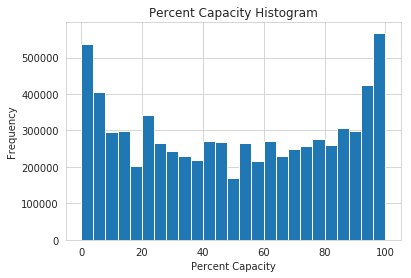

In [45]:
# Look at the distribution of percent capacities for full year of full data for all stations
discrete_bike_data_only = discrete_bike_data.copy()
pd.DataFrame.hist(discrete_bike_data_only, column='Count_Percent_Capacity',
                  bins=25)
plt.xlabel('Percent Capacity')
plt.ylabel('Frequency')
plt.title('Percent Capacity Histogram');

In [46]:
# Save to file
file = open('discrete_bike_data_only.csv', 'w')
file.write(discrete_bike_data_only['Count_Percent_Capacity'].to_csv())
file.close()

In [47]:
# What is the range of possible values of percent capacity?
print('Min percent capacity:', min(discrete_bike_data_only['Count_Percent_Capacity']))
print('Max percent capacity:', max(discrete_bike_data_only['Count_Percent_Capacity']))

Min percent capacity: 0.0
Max percent capacity: 100.0


Below I use boxplots to visualize the percent capacity for each station. Every 35 stations are plotted below:

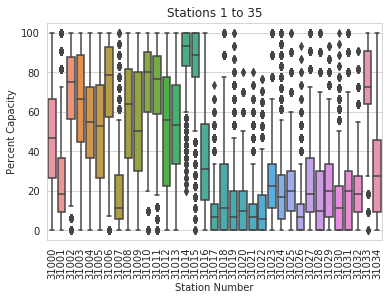

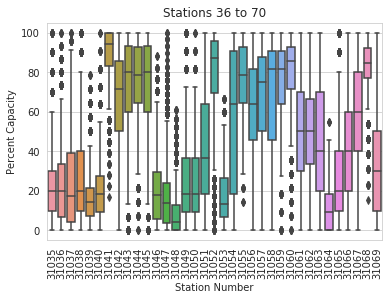

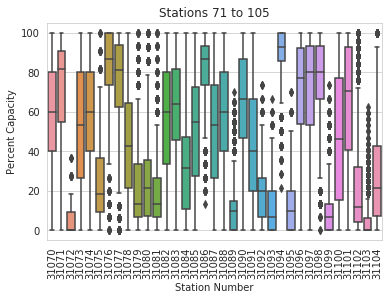

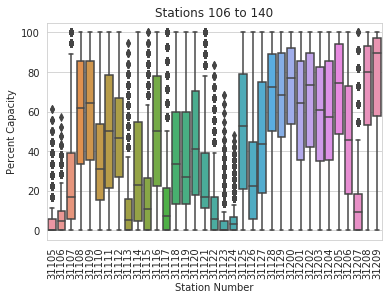

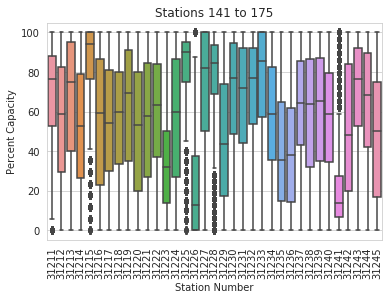

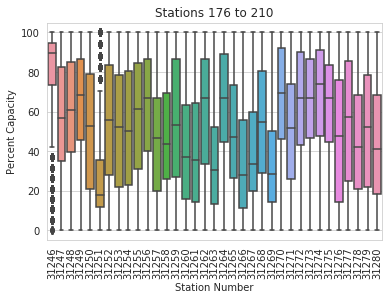

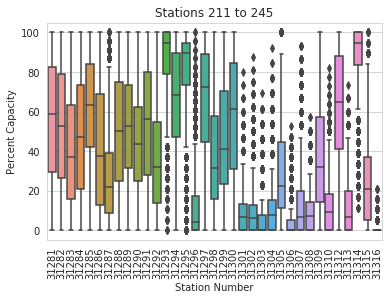

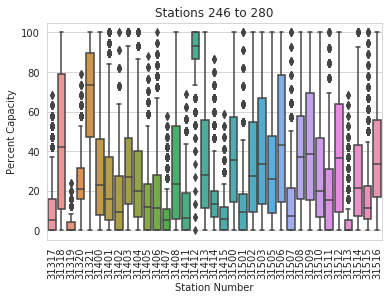

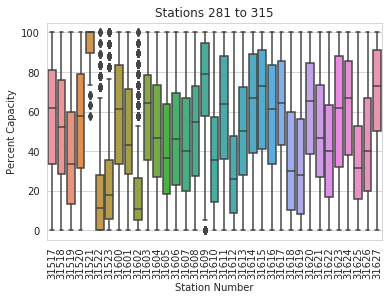

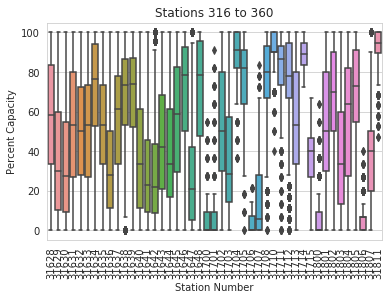

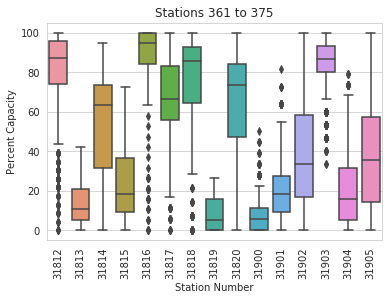

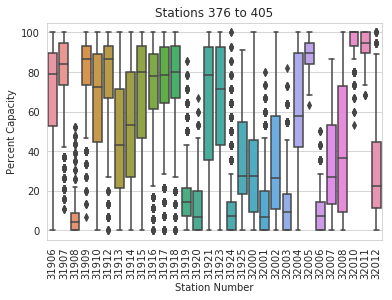

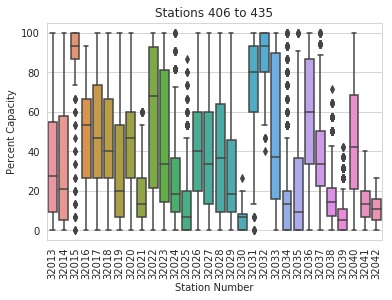

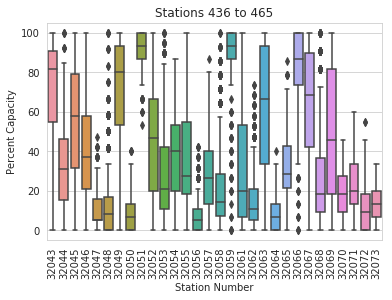

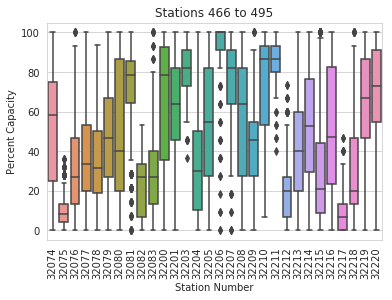

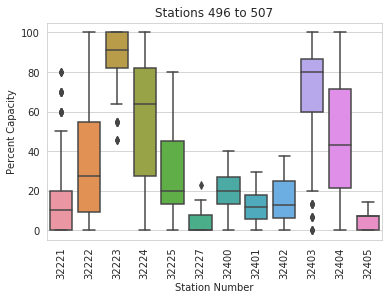

In [48]:
station_numbers = {0:35,35:70,70:105,105:140,140:175,175:210,210:245,245:280,280:315,315:360,360:375,375:405,405:435,435:465,465:495,495:507}

for number in sorted(list(station_numbers.keys())):
    station_list = []
    for station in sorted(list(bike_data['Start_Station_Number'].unique()))\
        [number:station_numbers[number]]:
        station_list.append(int(station))

    discrete_bike_data_filtered = \
        discrete_bike_data_only[discrete_bike_data_only['Station_Number'].isin(station_list)]
    ax = sns.boxplot(x="Station_Number", y="Count_Percent_Capacity", 
                     data=discrete_bike_data_filtered)
    if station_numbers[number] != None:
        plt.title('Stations {} to {}'.format(number+1, station_numbers[number]))
    else:
        plt.title('Stations {} to {}'\
                  .format(number, len(list(discrete_bike_data['Station_Number'].unique()))))
    plt.ylabel('Percent Capacity')
    plt.xlabel('Station Number')
    plt.xticks(rotation=90)
    plt.show();

<a id='Finaldf'></a>
# How do we handle the fact that the data is irregular?
Since the timeseries was made up of every single pick and drop off of bikes within the time period, the data is very irregular. To change this, I will upsample to every 1 hour and use linear interpolation to fill in the new percent capacity values
[Back to Top](#top)

In [52]:
# For each station, resample data for every 1 hour 
# and use a forward fill to create a new dataframe
final_bike_data = pd.DataFrame()
add_hour = datetime.timedelta(hours=1)

for station in list(discrete_bike_data_only['Station_Number'].unique()):
    temp_df = discrete_bike_data_only[discrete_bike_data_only['Station_Number'] == station]
    
    start = temp_df['Date'].iloc[0] + datetime.timedelta(seconds=1)
    end = temp_df['Date'].iloc[-1]
    new_datetimes = []

    while start <= (end + add_hour):
        new_datetimes.append(start)
        start += add_hour
        
    new_datetimes_df = pd.DataFrame({'Date':new_datetimes, 
                                     'Station_Number':'new_datetime'})
    
    updated_temp_df = temp_df.append(new_datetimes_df)
    updated_temp_df.sort_values(by='Date', inplace=True)
    updated_temp_df['Count_Percent_Capacity'] = \
        updated_temp_df['Count_Percent_Capacity'].interpolate(method='linear')
    updated_temp_df = updated_temp_df[updated_temp_df['Station_Number'] != station]
    updated_temp_df['Station_Number'] = station
    
    final_bike_data = final_bike_data.append(updated_temp_df)

In [53]:
# How much data do I have now?
final_bike_data.info()
final_bike_data.head(2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4295220 entries, 0 to 96
Data columns (total 6 columns):
Bike_Count                float64
Count_Percent_Capacity    float64
Date                      datetime64[ns]
Start_Station_Capacity    float64
Station_Number            int64
Status                    object
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 229.4+ MB


,Bike_Count,Count_Percent_Capacity,Date,Start_Station_Capacity,Station_Number,Status
0,NaN,2.631579,2017-09-01 07:39:48,NaN,31289,NaN
1,NaN,0.000000,2017-09-01 08:39:48,NaN,31289,NaN


In [54]:
# Writing final dataframe to file in csv
file = open('final_bike_data.csv', 'w')
file.write(final_bike_data.to_csv())
file.close()

<a id='forecast'></a>  
# Capacity forecast for each station  
[Back to Top](#top)

In [4]:
import warnings; warnings.simplefilter('ignore')
import pandas as pd
import os
from mapboxgl.utils import *
from mapboxgl.viz import *
import pysal.esda.mapclassify as mapclassify
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
cwd = os.getcwd()


In [5]:
# load in final bike data
tsdata = pd.read_csv(cwd+'/final_bike_data.csv',parse_dates=['Date'], infer_datetime_format=True, index_col=0)
tsdata = tsdata.set_index('Date')
tsdata= (tsdata.resample('d')).mean()#find the mean for Bike count resampling by day
#data['Date'] = pd.to_datetime((data.Date.map(lambda x: x.strftime('%Y-%m-%d'))))

# Examine the first few rows and data types
print(tsdata.head(2))
print('\n Data Types:')
print(tsdata.dtypes)

            Bike_Count  Count_Percent_Capacity  Start_Station_Capacity  \
Date                                                                     
2017-07-01         NaN                4.332394                     NaN   
2017-07-02         NaN                7.953604                     NaN   

            Station_Number  Status  
Date                                
2017-07-01    31887.048649     NaN  
2017-07-02    31965.257831     NaN  

 Data Types:
Bike_Count                float64
Count_Percent_Capacity    float64
Start_Station_Capacity    float64
Station_Number            float64
Status                    float64
dtype: object


The data contains a datetime index with a particular year, month, and day under **Date** and a column of station capacity percentages under **Count_Percent_Capacity**. The other columns will be dropped as they are not useful for the following analysis.

In [6]:
tsdata.drop(['Bike_Count','Start_Station_Capacity','Station_Number','Status'], axis=1, inplace=True)
tsdata.head(2)

,Count_Percent_Capacity
Date,
2017-07-01,4.332394
2017-07-02,7.953604


Visually checking how Stationary this dataset is currently.

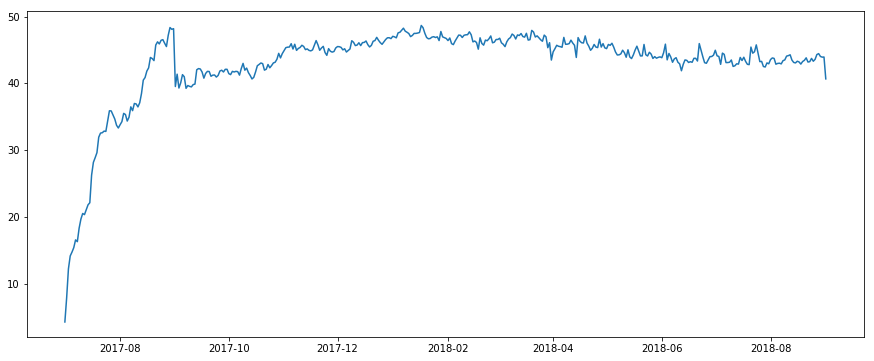

In [7]:
# Simple plot for a visual check
ts = tsdata['Count_Percent_Capacity']
plt.plot(ts)

It is clear this are a few upward and downward trends that happen throughout time. 
To be exact I will:
    1) **Plot Rolling Statistics**
    2) **Perform a Dickey-Fuller Test**

In [13]:
from statsmodels.tsa.stattools import adfuller
import numpy as np
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    #note standard deviation instead of variance to keep the units similar to mean
    ts_log = np.log(ts)
    rolmean = ts_log.rolling(12).mean()
    rolstd = ts_log.rolling(12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print( dfoutput)

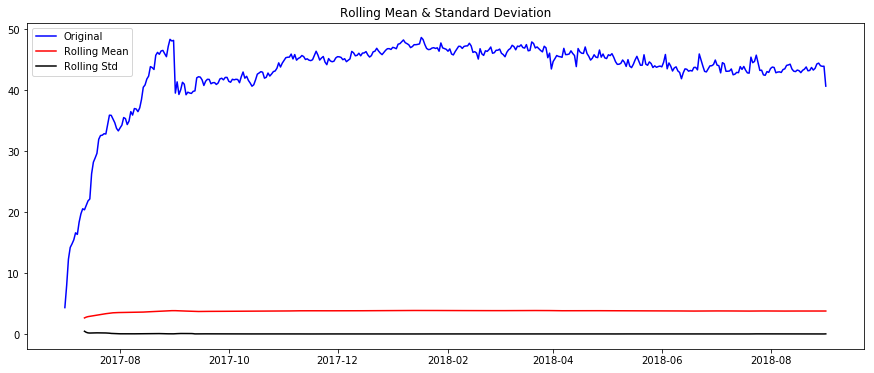

Results of Dickey-Fuller Test:
Test Statistic                -8.167803e+00
p-value                        8.786708e-13
#Lags Used                     1.000000e+00
Number of Observations Used    4.260000e+02
Critical Value (1%)           -3.445794e+00
Critical Value (5%)           -2.868349e+00
Critical Value (10%)          -2.570397e+00
dtype: float64


In [14]:
test_stationarity(ts)

The variation in standard deviation and mean are small. Also, in the Dickey-Fuller Test, after comapring signed values the test statistic is way less than all the critical values. However, we can make this more stationary by removing trend and seasonality.
 

## Estimating & Eliminating Trend


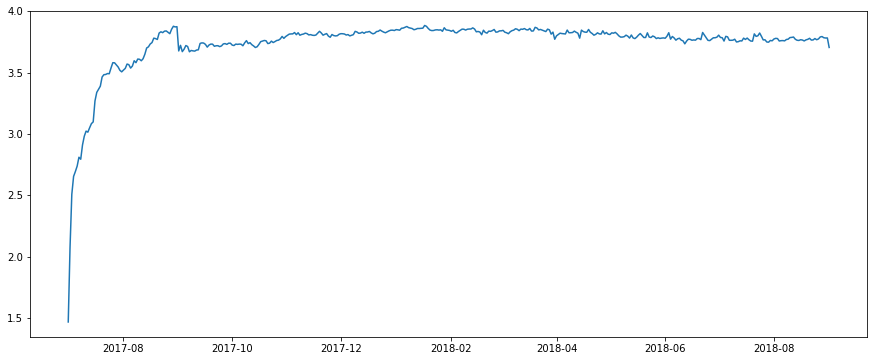

In [15]:
#log transformation
ts_log = np.log(ts)
plt.plot(ts_log)

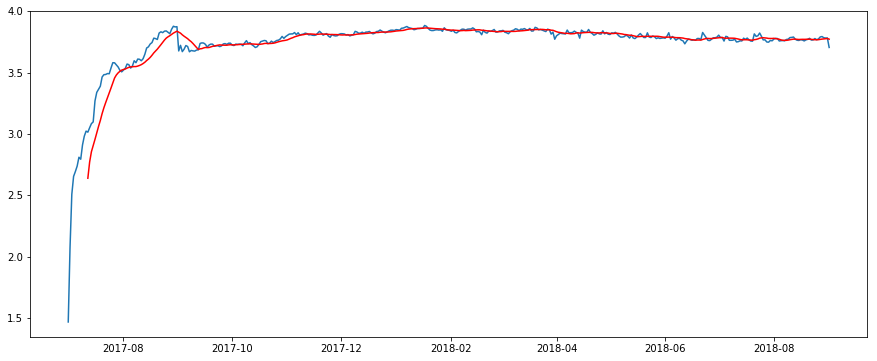

In [16]:
#Moving Average
moving_avg = ts_log.rolling(12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [17]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(12)

Date
2017-07-01         NaN
2017-07-02         NaN
2017-07-03         NaN
2017-07-04         NaN
2017-07-05         NaN
2017-07-06         NaN
2017-07-07         NaN
2017-07-08         NaN
2017-07-09         NaN
2017-07-10         NaN
2017-07-11         NaN
2017-07-12    0.375955
Freq: D, Name: Count_Percent_Capacity, dtype: float64

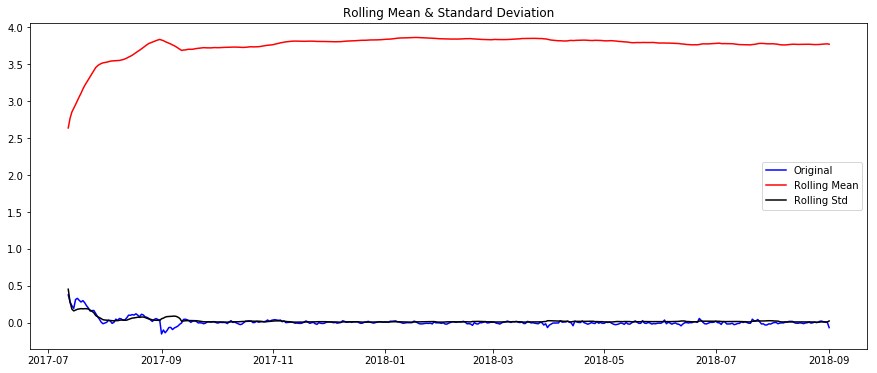

Results of Dickey-Fuller Test:
Test Statistic                -7.282207e+00
p-value                        1.490236e-10
#Lags Used                     1.100000e+01
Number of Observations Used    4.050000e+02
Critical Value (1%)           -3.446600e+00
Critical Value (5%)           -2.868703e+00
Critical Value (10%)          -2.570586e+00
dtype: float64


In [18]:
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

I can say with 99% confidence that this is a stationary series.

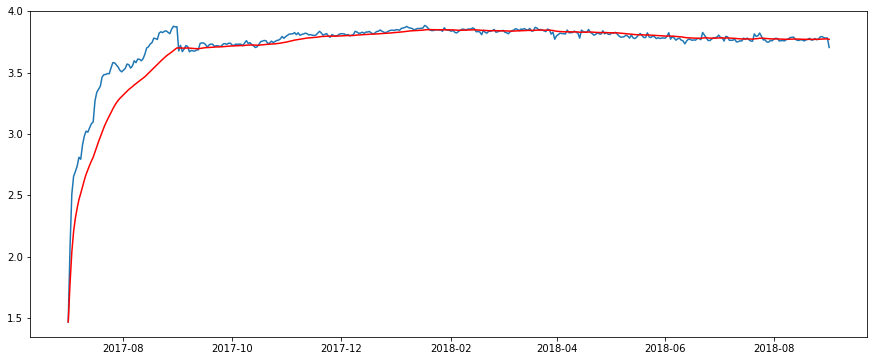

In [19]:
expwighted_avg = ts_log.ewm(halflife=12).mean()#com=7, Note that here the parameter ‘halflife’ is used to define the amount of exponential decay.
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')

I will now take the exponentially weighted moving average to give more weight to recent values.

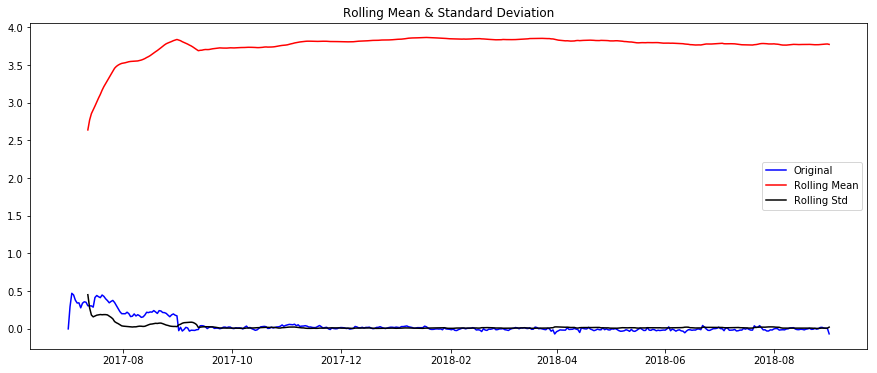

Results of Dickey-Fuller Test:
Test Statistic                  -4.392070
p-value                          0.000307
#Lags Used                      15.000000
Number of Observations Used    412.000000
Critical Value (1%)             -3.446322
Critical Value (5%)             -2.868581
Critical Value (10%)            -2.570521
dtype: float64


In [20]:
ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff)

## Eliminating Trend and Seasonality

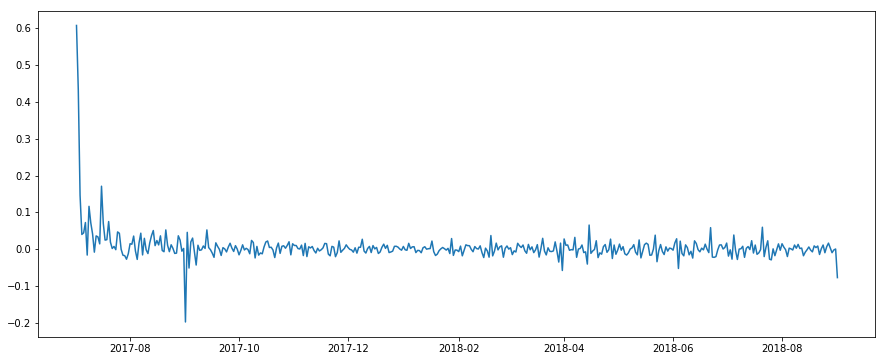

In [21]:
#Differencing
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

In [22]:
#Forward fill misisng values
ffil_tlog =ts_log.fillna(method='ffill')

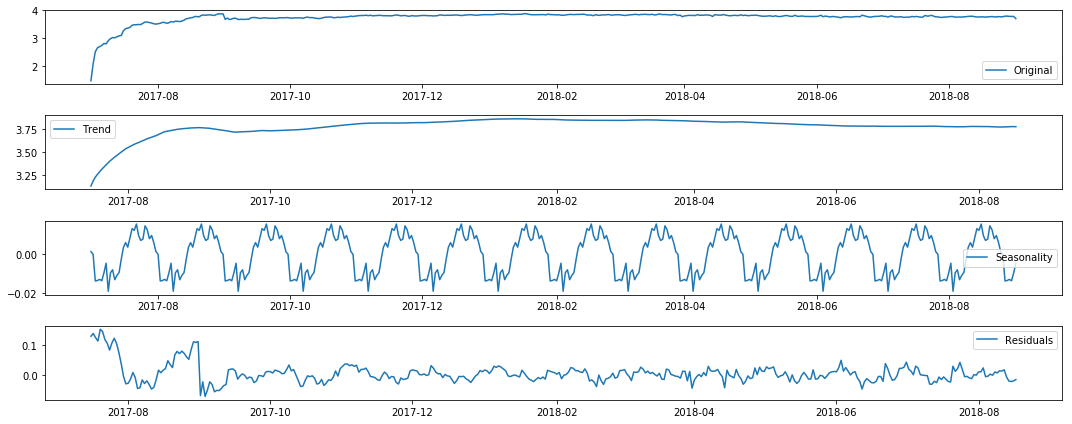

In [23]:
# Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ffil_tlog,freq=30)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ffil_tlog, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

Here we can see that the trend, seasonality are separated out from data and we can model the residuals. Lets check stationarity of residuals:

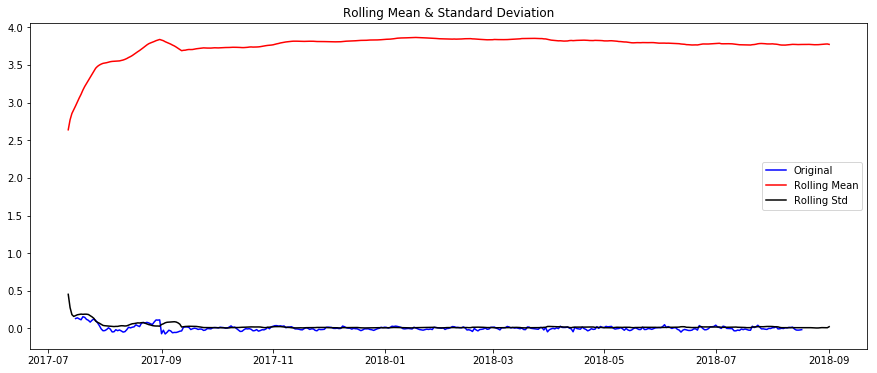

Results of Dickey-Fuller Test:
Test Statistic                -8.342503e+00
p-value                        3.148459e-13
#Lags Used                     9.000000e+00
Number of Observations Used    3.880000e+02
Critical Value (1%)           -3.447317e+00
Critical Value (5%)           -2.869018e+00
Critical Value (10%)          -2.570754e+00
dtype: float64


In [24]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

In [25]:
from statsmodels.tsa.stattools import acf, pacf

In [27]:
# ts_log_diff contains inf or nans so we drop them here
ts_log_diff.dropna(inplace=True)
ts_log_diff=ts_log_diff.replace([np.inf, -np.inf], np.nan).dropna(axis=0)

lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

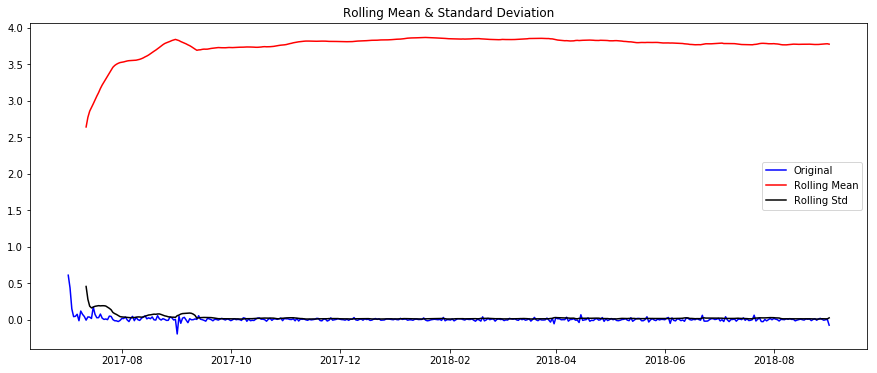

Results of Dickey-Fuller Test:
Test Statistic                -6.316872e+00
p-value                        3.134862e-08
#Lags Used                     8.000000e+00
Number of Observations Used    4.180000e+02
Critical Value (1%)           -3.446091e+00
Critical Value (5%)           -2.868479e+00
Critical Value (10%)          -2.570466e+00
dtype: float64


In [28]:
test_stationarity(ts_log_diff)

## The ACF and PACF plots for the TS after differencing

Text(0.5,1,'Autocorrelation Function')

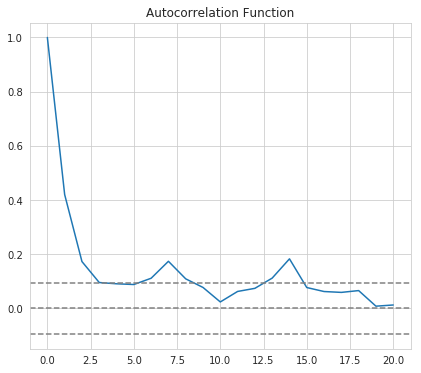

In [76]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

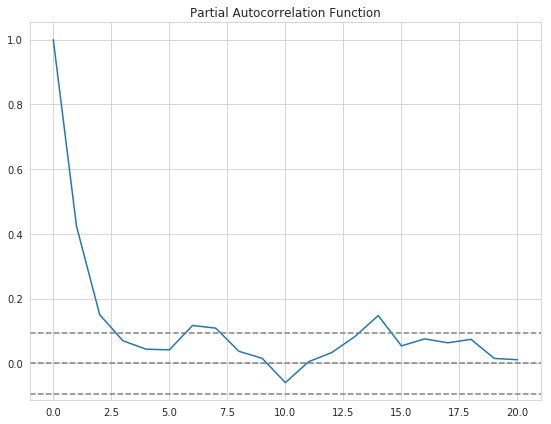

In [77]:
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

## AR Model

Text(0.5,1,'RSS: 0.8008')

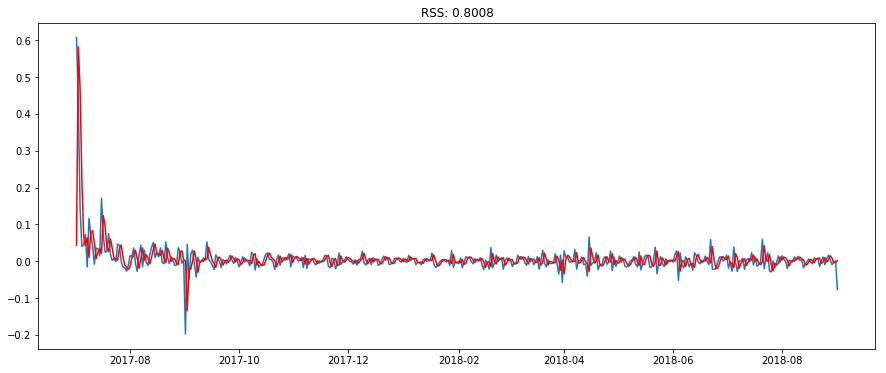

In [29]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(ts_log, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))

## MA Model

Text(0.5,1,'RSS: 0.6861')

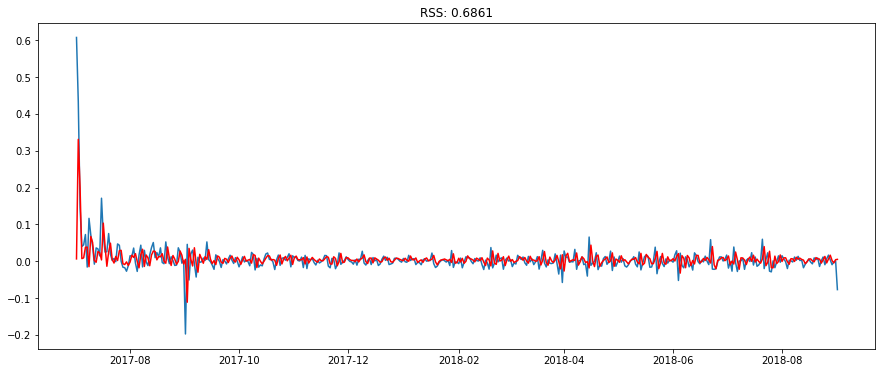

In [30]:
model = ARIMA(ts_log, order=(0, 1, 2))  
results_MA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))

Text(0.5,1,'RSS: 0.7913')

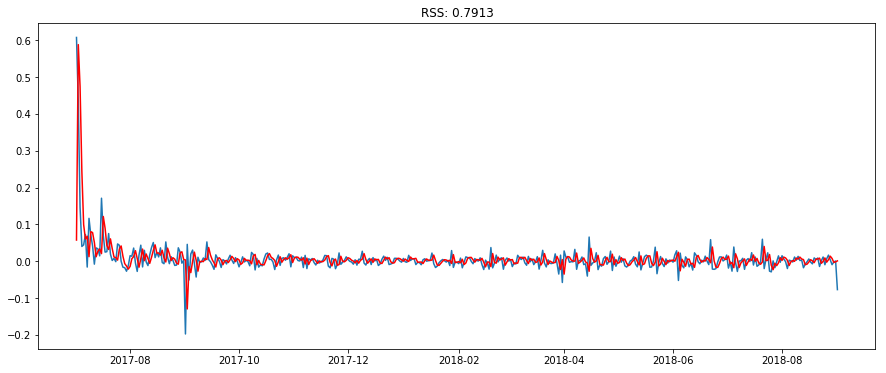

In [31]:
model = ARIMA(ts_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

Here we can see that the AR and combined models have almost the same residual sum square(RSS) but MA is significantly better. Now, we are left with 1 last step, i.e. taking these values back to the original scale.

## Taking it back to original scale

In [48]:
predictions_MA_diff = pd.Series(results_MA.fittedvalues, copy=True)
print(predictions_MA_diff.head())

Date
2017-07-02    0.006080
2017-07-03    0.330796
2017-07-04    0.199743
2017-07-05    0.006871
2017-07-06    0.008881
Freq: D, dtype: float64


In [49]:
predictions_MA_diff_cumsum = predictions_MA_diff.cumsum()
print(predictions_MA_diff_cumsum.head())

Date
2017-07-02    0.006080
2017-07-03    0.336876
2017-07-04    0.536619
2017-07-05    0.543490
2017-07-06    0.552371
Freq: D, dtype: float64


In [53]:
predictions_MA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_MA_log = predictions_MA_log.add(predictions_MA_diff_cumsum,fill_value=0)
predictions_MA_log.head()

Date
2017-07-01    1.466120
2017-07-02    1.472200
2017-07-03    1.802996
2017-07-04    2.002739
2017-07-05    2.009610
Freq: D, dtype: float64

Text(0.5,1,'RMSE: 19.0963')

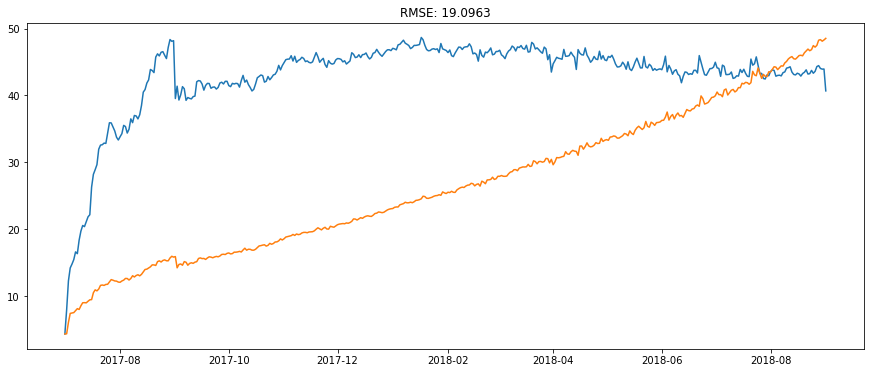

In [54]:
predictions_MA = np.exp(predictions_MA_log)
plt.plot(ts)
plt.plot(predictions_MA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_MA-ts)**2)/len(ts)))